## Plotting the distribution of programming languages

In [57]:
import urllib.request
from unidiff import PatchSet
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from pandas import json_normalize
from tabulate import tabulate 
import glob
import time
from pathlib import Path
import re
import git
from urllib.parse import urlparse
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# DB_DIR = 'data/FixMe/Fixme-first.db'
DB_FILE = '/Users/guru/research/FixMe/data/FixMe.db'
conn = f'sqlite:///{DB_FILE}'

In [58]:
# get cve table from db
df_cve = pd.read_sql_table(
    table_name='cve', 
    con=conn
    )
# get patch table from db
df_hunk = pd.read_sql_table(
    table_name='hunk_collection', 
    con=conn
    )

# get patch table from db
df_patch = pd.read_sql_table(
    table_name='patch_collection', 
    con=conn
    )
df_cve.head(5)

,file,hunk,hunk_patch,source,target,source_lines,target_lines,added_lines,removed_lines,before_code,after_code,source_start,source_length,target_start,target_length,section_header,hunk_length,programming_language
0,src/libraw_cxx.cpp,"@@ -2336,14 +2336,15 @@ int LibRaw::subtract_b...","@@ -2336,14 +2336,15 @@ int LibRaw::subtract_b...","[' #define MAX(a,b) ((a) > (b) ? (a) : (b))\n'...","[' #define MAX(a,b) ((a) > (b) ? (a) : (b))\n'...",<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,"['\t\t\tint dmax = 0;\n', '\t\t\tfor(i=0; i< s...","['\n', ' for(i=0; i< size*4; i++)\n...","#define MAX(a,b) ((a) > (b) ? (a) : (b))\n#def...","#define MAX(a,b) ((a) > (b) ? (a) : (b))\n#def...",2336,14,2336,15,int LibRaw::subtract_black(),18,C++
1,src/libraw_cxx.cpp,"@@ -2359,9 +2360,10 @@ int LibRaw::subtract_bl...","@@ -2359,9 +2360,10 @@ int LibRaw::subtract_bl...",[' // only calculate channel maximum...,[' // only calculate channel maximum...,<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,"['\t\t int dmax = 0;\n', ' if(dmax...","[' C.data_maximum = 0;\n', ' ...",// only calculate channel maximum;\n...,// only calculate channel maximum;\n...,2359,9,2360,10,int LibRaw::subtract_black(),12,C++
2,src/libraw_cxx.cpp,"@@ -2421,8 +2423,10 @@ void LibRaw::exp_bef(fl...","@@ -2421,8 +2423,10 @@ void LibRaw::exp_bef(fl...",[' imgdata.image[i][3] = lut[imgda...,[' imgdata.image[i][3] = lut[imgda...,<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,"['\tif(C.data_maximum <=TBLN)\n', '\t\tC.data_...",[' C.data_maximum = lut[C.data_maximum];\n'...,imgdata.image[i][3] = lut[imgdata....,imgdata.image[i][3] = lut[imgdata....,2421,8,2423,10,"void LibRaw::exp_bef(float shift, float smooth)",12,C++
3,src/libraw_cxx.cpp,"@@ -2530,7 +2534,7 @@ int LibRaw::dcraw_proces...","@@ -2530,7 +2534,7 @@ int LibRaw::dcraw_proces...","[' \n', ' raw2image_ex(subtract_inline...","[' \n', ' raw2image_ex(subtract_inline...",<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,['\t\tint save_4color = O.four_color_rgb;\n'],[' int save_4color = O.four_color_rgb;\n'],\n raw2image_ex(subtract_inline); // al...,\n raw2image_ex(subtract_inline); // al...,2530,7,2534,7,int LibRaw::dcraw_process(void),8,C++
4,hawtjni-runtime/src/main/java/org/fusesource/h...,"@@ -9,13 +9,11 @@\n *************************...","@@ -9,13 +9,11 @@\n *************************...",[' ******************************************...,[' ******************************************...,<bound method Hunk.source_lines of <Hunk: @@ 9...,<bound method Hunk.target_lines of <Hunk: @@ 9...,"['import java.io.*;\n', 'import java.util.Rand...","['import java.io.File;\n', 'import java.io.Fil...",*********************************************...,*********************************************...,9,13,9,11,,15,Java


# Scanning CVEs for git-based commit URLs

[10615  1155   278   226   217   199   188   174   171   162]


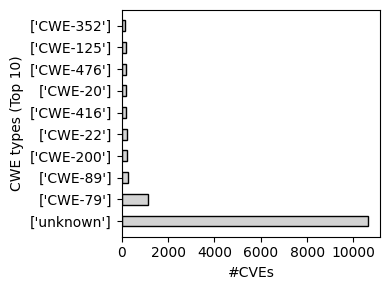

In [60]:
vals = df_cve.problemTypes.value_counts().head(10)
x = [str(x) for x in vals.index]
print(vals.values)

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(x, width=vals.values,color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('CWE types (Top 10)')
ax.set_xlabel('#CVEs')
plt.tight_layout()
plt.savefig(f'figure/CWE-types.png')
plt.show()

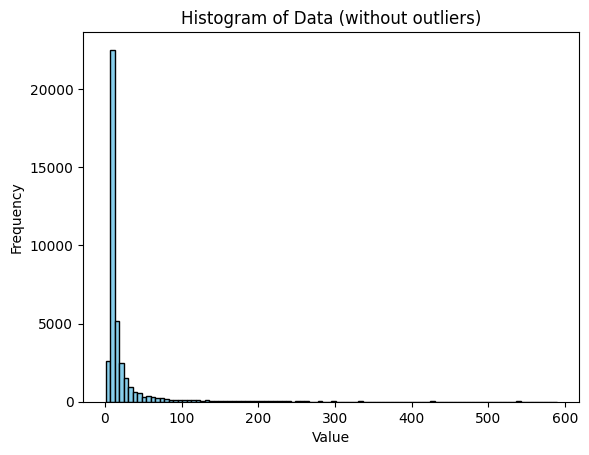

In [61]:
# Calculate mean and standard deviation
data = df_hunk.hunk_length.astype(int)

# Convert the list to a numpy array for easier computation
data_array = np.array(data)

# Calculate mean and standard deviation
mean = np.mean(data_array)
std_dev = np.std(data_array)

# Define the range for non-outliers (e.g., within 3 standard deviations)
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Filter out outliers
data_no_outliers = [x for x in data if (x >= lower_bound) and (x <= upper_bound)]

# Plot histogram of non-outliers
plt.hist(data_no_outliers, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Data (without outliers)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


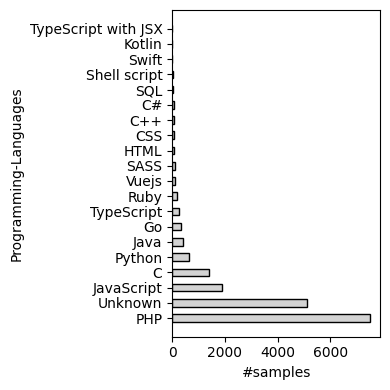

In [62]:
# plot_value_counts(col=df_patch['pl'], xlabel='Programming-Languages', ylabel='#patches')


pls = df_patch['programming_language'].value_counts().head(20)

fig, ax = plt.subplots(figsize=(4, 4))
bar_width = 0.5
bars = ax.barh(pls.index, pls.values, color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('Programming-Languages')
ax.set_xlabel('#samples')
plt.tight_layout()
plt.savefig(f'figure/Programming-Languages.png')
plt.show()


In [63]:
df_hunk.columns

Index(['file', 'hunk', 'hunk_patch', 'source', 'target', 'source_lines',
       'target_lines', 'added_lines', 'removed_lines', 'before_code',
       'after_code', 'source_start', 'source_length', 'target_start',
       'target_length', 'section_header', 'hunk_length',
       'programming_language'],
      dtype='object')

# The function that counts the length of words in the values of a specified column in a DataFrame and plots the distribution as a histogram:

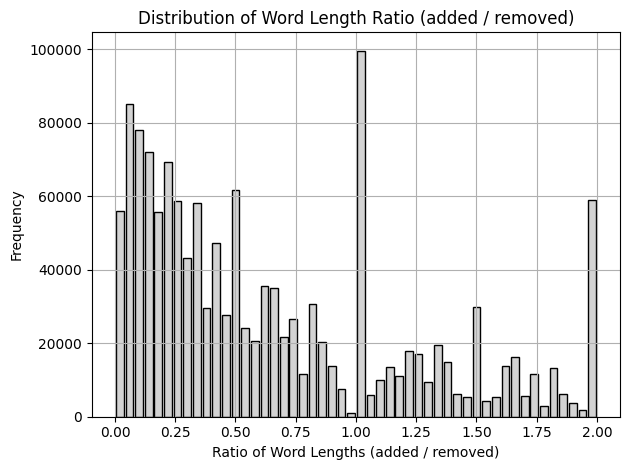

In [64]:
def count_and_plot_word_length_ratio(df, column1, column2):
    """
    Count the length of words in the values of two specified columns in a DataFrame,
    compute the ratio of corresponding word lengths, and plot the distribution as a histogram.
    """
    # Tokenize words and count lengths for both columns
    word_lengths1 = [len(word) for value in df[column1] for word in str(value).split()]
    word_lengths2 = [len(word) for value in df[column2] for word in str(value).split()]

    # Compute the ratio of word lengths
    word_length_ratio = [length2 / length1 if length1 != 0 else float('NaN') for length1, length2 in zip(word_lengths1, word_lengths2)]

    # Plot histogram
    plt.hist(word_length_ratio, bins=50, range=(0, 2), rwidth=0.8, color='lightgray', edgecolor='black')
    plt.xlabel('Ratio of Word Lengths (added / removed)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Word Length Ratio (added / removed)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figure/word-length-ratio.png')
    plt.show()
    return word_length_ratio

word_length_ratio = count_and_plot_word_length_ratio(df_hunk, 'removed_lines', 'added_lines')

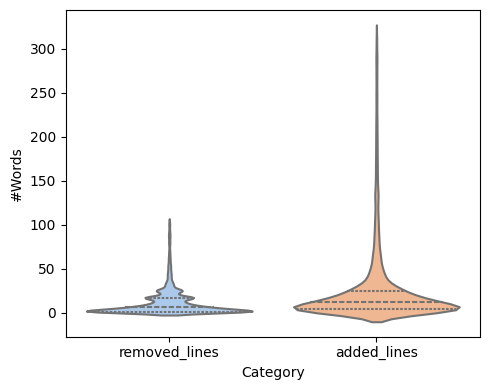

In [65]:
def count_and_plot_word_lengths(df, column1, column2, outlier_threshold=0.95):
    """
    Count the number of words in the values of two specified columns in a DataFrame
    and plot the distributions as violin plots side by side."""

    # Count number of words for both columns
    word_counts1 = [len(str(value).split()) for value in df[column1]]
    word_counts2 = [len(str(value).split()) for value in df[column2]]

    # Identify outliers using quantiles
    max_outlier_count1 = np.quantile(word_counts1, outlier_threshold)
    max_outlier_count2 = np.quantile(word_counts2, outlier_threshold)

    # Filter out outliers
    filtered_word_counts1 = [count for count in word_counts1 if count <= max_outlier_count1]
    filtered_word_counts2 = [count for count in word_counts2 if count <= max_outlier_count2]
    
    # Combine word counts from both columns without outliers
    combined_word_counts = {'Category': [column1]*len(filtered_word_counts1) + [column2]*len(filtered_word_counts2),
                            '#Words': filtered_word_counts1 + filtered_word_counts2}

    # Create DataFrame from combined data
    combined_df = pd.DataFrame(combined_word_counts)

    # Plot violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(x='Category', y='#Words', data=combined_df, inner='quartile', hue='Category', palette='pastel', color='lightgray', linewidth=1.5, width=0.8)
    plt.xlabel('Category')
    plt.ylabel('#Words')
    plt.tight_layout()
    plt.savefig(f'figure/word-counts-violin.png')
    plt.show()

# Call the function with the DataFrame and column names
count_and_plot_word_lengths(df_hunk, 'removed_lines', 'added_lines')

# Plotting of original CVEs and those included FixMe

In [66]:
def find_json_files(directory):
    """Find all JSON files in the given directory (including subdirectories)."""
    json_files = glob.glob(os.path.join(
        directory, "**/*.json"), recursive=True)
    json_files = [Path(x).stem for x in json_files]
    return [x for x in json_files if 'cve' in x.lower()]

total_cves= find_json_files('/Users/guru/research/FixMe/data/cvelistV5/cves')
print(f"Total CVEs: {len(total_cves)}")
ref_cves = df_cve.cveId.tolist()
print(f"Total CVEs in DB: {len(ref_cves)}")

Total CVEs: 241552
Total CVEs in DB: 17447


In [67]:
years_cve_total = [file.split('-')[1] for file in total_cves]
years_cve_ref = [file.split('-')[1] for file in ref_cves]

freq_total = pd.Series(years_cve_total).value_counts().sort_index()
freq_ref = pd.Series(years_cve_ref).value_counts().sort_index()
# Get unique years from both Series
all_years = sorted(set(freq_total.index) | set(freq_ref.index))

# Reindex both Series with all years and fill NaN (missing values) with 0
freq_total= freq_total.reindex(all_years, fill_value=0)
freq_ref = freq_ref.reindex(all_years, fill_value=0)

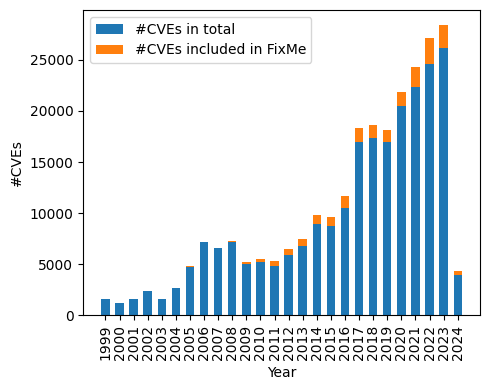

In [68]:
fig, ax = plt.subplots(figsize=(5, 4))
bar_width = 0.6
index = range(len(freq_total))

bar1 = ax.bar(freq_total.index, freq_total.values, bar_width, label='#CVEs in total')
bar2 = ax.bar(freq_ref.index, freq_ref.values, bar_width, label='#CVEs included in FixMe', bottom=freq_total.values)

# Adding labels, title, and legend
ax.set_xlabel('Year')
ax.set_ylabel('#CVEs')
ax.set_xticks(index)
ax.set_xticklabels(freq_total.index, rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig('figure/cve_yearly_bar.png', bbox_inches='tight', dpi=300)
plt.show()

## Alternatively

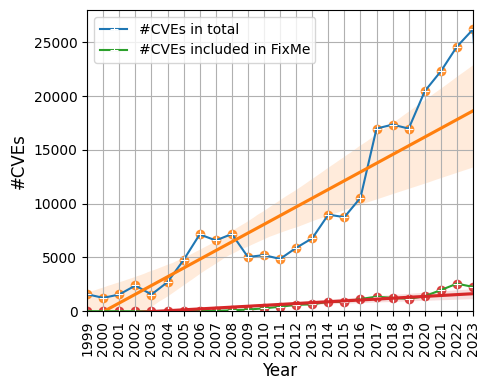

In [69]:
df = pd.DataFrame({'year': freq_total.index.astype(int), 'count': freq_total.values.astype(int)})
df['count2'] = freq_ref.values.astype(int)

df.index = df['year']
df.rename(columns={'count': '#CVEs in total', 'count2': '#CVEs included in FixMe'}, inplace=True)

plt.figure(figsize=(5, 4))

for column in df.columns:
    if column != 'year':
        sns.lineplot(x=df.index, y=df[column], marker='+', linestyle='-', label=column)
        # sns.barplot(x=df.index, y=df[column], alpha=0.2, label=column)
        sns.regplot(x=df.index, y=df[column], scatter=True)

plt.xlabel('Year', fontsize=12)
plt.ylabel('#CVEs', fontsize=12)
# plt.title('Trend of CVEs Each Year')
plt.xticks(df.year, rotation=90)  
plt.xlim(1999, 2023)  
plt.ylim(0, 28000)
plt.grid() 
plt.legend(loc='upper left', fontsize=10)  
plt.tight_layout()
plt.savefig('figure/cve_yearly_line.png', bbox_inches='tight', dpi=300)
plt.show()